## M5-Forecasting-Starter-Data-Exploration
date : 2020-05-05 <br>
[kaggle ] https://www.kaggle.com/c/m5-forecasting-accuracy <br>
[kaggle 참고 커널] https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration

### Competition 두가지 : Accuracy and Uncertainty
* The accuracy competition 은 Weighted Root Mean Squared Scaled Error (RMSSE) 사용
* The uncertainty competition 은 Weighted Scaled Pinball Loss (WSPL) 사용

### Competitione 목적
* walmart의 판매데이터를 예측하는것

------------------------------------------------------------------------------------------------
### Data Files
* calendar.csv - Contains information about the dates on which the products are sold.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
* sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
* sell_prices.csv - Contains information about the price of the products sold per store and date.

Not available yet:
* sales_train_evaluation.csv - Available one month before competition deadline. Will include sales [d_1 - d_1941]
------------------------------------------------------------------------------------------------


In [3]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [4]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

### 정확히 예측하려는게 무엇인가
28일의 판매량을 예측하는것. sample submission은 아래 format으로 구성되어있다.

* 컬럼은 28개의 예측일자를 나타낸다. 우리는 이 forecast days를 예측해서 값을 채울것이다.
* 각각의 row는 특정 item을 나타낸다. 이 id는 상품 종류, 상태, 상점을 나타낸다. 정확히 이 아이템이 무엇인지는 모름.


In [6]:
cal=pd.read_csv("./data/calendar.csv")
sellp=pd.read_csv("./data/sell_prices.csv")
stv = pd.read_csv("./data/sales_train_validation.csv")
ss= pd.read_csv("./data/sample_submission.csv")

In [7]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
ss.shape

(60980, 29)

sales_train_validation dataset에 이전의 판매 데이터가 있다.
* row는 days d_1 to d_1913 까지 데이터가 있다. department, 카테고리, 상품상태, 그리고 상점_id가 주어져있다.
* d_1914 - d_1941 은 validation rows 로서, stage1에서 우리가 예측할 데이터
* d_1942 - d_1969  은 evaluation rows로서, 최종적으로 예측할 데이터

In [6]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [7]:
stv.shape

(30490, 1919)

### Visualizing the data for a single item
* Lets take a random item that sell a lot and see how it's sales look across the training data.
* FOODS_3_090_CA_3_validation sells a lot
* Note there are days where it appears the item is unavailable and sales flatline

In [8]:
# 원하는 데이터형태로 변형
d_cols=[c for c in stv.columns if 'd_' in c]
stv.query('id=="FOODS_3_090_CA_3_validation" ').set_index('id')[d_cols].T

id,FOODS_3_090_CA_3_validation
d_1,108
d_2,132
d_3,102
d_4,120
d_5,106
...,...
d_1909,88
d_1910,77
d_1911,141
d_1912,139


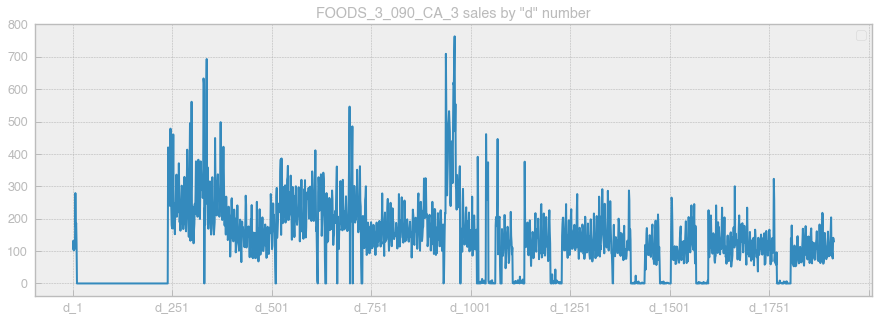

In [9]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

### Merging the data with real dates
* We are given a calendar with additional information about past and future dates.
* The calendar data can be merged with our days data
* From this we can find weekly and annual trends

In [16]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


In [17]:
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].dropna()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
85,d_86,2011-04-24,OrthodoxEaster,Easter,Religious,Cultural,0
827,d_828,2013-05-05,OrthodoxEaster,Cinco De Mayo,Religious,Cultural,1
1177,d_1178,2014-04-20,Easter,OrthodoxEaster,Cultural,Religious,0
1233,d_1234,2014-06-15,NBAFinalsEnd,Father's day,Sporting,Cultural,0
1968,d_1969,2016-06-19,NBAFinalsEnd,Father's day,Sporting,Cultural,0


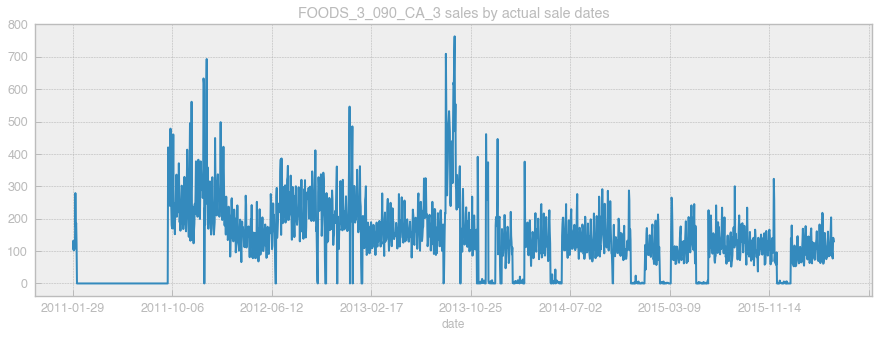

In [9]:
# Merge calendar on our items' data
example= stv.query('id=="FOODS_3_090_CA_3_validation"')[d_cols].T
example=example.rename(columns={8412:'FOODS_3_090_CA_3'}).reset_index().rename(columns={'index':'d'})
example = example.merge(cal, how='left', validate='1:1') # cal 데이터와 merge
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [10]:
# Select more top selling examples
example2 = stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(cal, how='left', validate='1:1')

example3 = stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(cal, how='left', validate='1:1')

### Sales broken down by time variables
* Now that we have our example item lets see how it sells by:
    * Day of the week
    * Month
    * Year

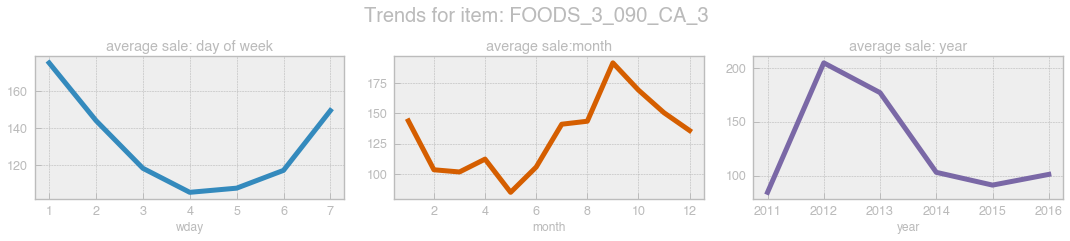

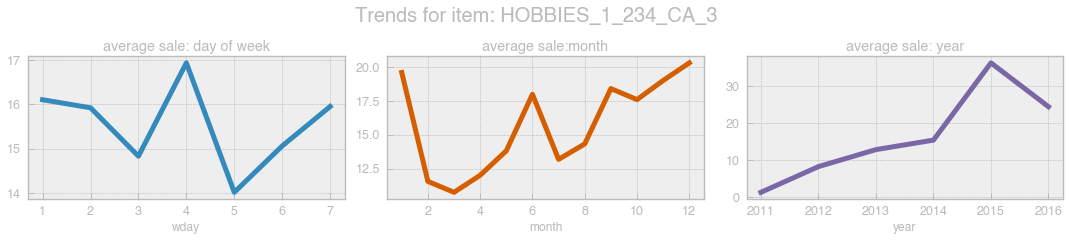

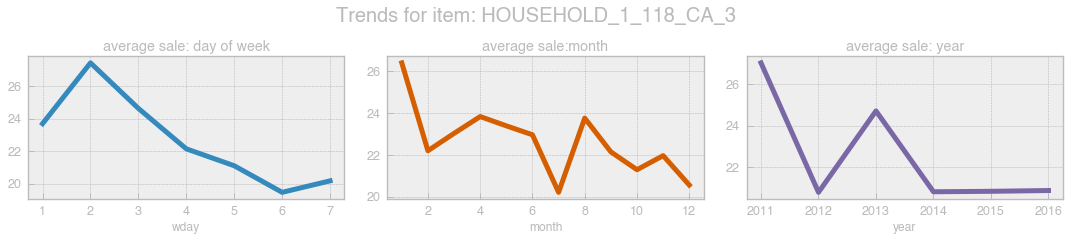

In [11]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0,1,2]:
    fig,(ax1,ax2,ax3)= plt.subplots(nrows=1, ncols=3, figsize=(15,3))
    example_df[i].groupby('wday').mean()[examples[i]]\
        .plot(kind='line',
             title='average sale: day of week',
             lw=5,
             color=color_pal[0],
             ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]]\
        .plot(kind='line',
             title='average sale:month',
             lw=5,
             color=color_pal[4],
             ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                size=20,
                y=1.1)
    plt.tight_layout()
    plt.show()

### Lets look at a lot of different items!
* Lets put it all together to plot 20 different items and their sales
* Some observations from these plots:
    * It is common to see an item unavailable for a period of time.
    * Some items only sell 1 or less in a day, making it very hard to predict.
    * Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these.

In [12]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [114]:
twenty_examples.head(3)

,FOODS_1_013_TX_1_validation,HOUSEHOLD_1_311_WI_1_validation,FOODS_3_805_CA_3_validation,HOUSEHOLD_2_369_TX_2_validation,HOUSEHOLD_1_080_TX_2_validation,HOUSEHOLD_1_463_CA_2_validation,FOODS_2_046_CA_1_validation,HOUSEHOLD_2_102_WI_3_validation,FOODS_2_131_TX_2_validation,HOUSEHOLD_2_115_WI_1_validation,HOUSEHOLD_1_192_CA_3_validation,FOODS_3_641_CA_1_validation,FOODS_2_110_WI_2_validation,HOUSEHOLD_2_060_TX_2_validation,FOODS_3_018_CA_3_validation,FOODS_1_137_WI_2_validation,FOODS_3_667_CA_2_validation,FOODS_2_162_WI_1_validation,HOBBIES_2_142_TX_2_validation,FOODS_1_053_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0,1,0
2011-01-30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0
2011-01-31,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,6,0,0,0,0


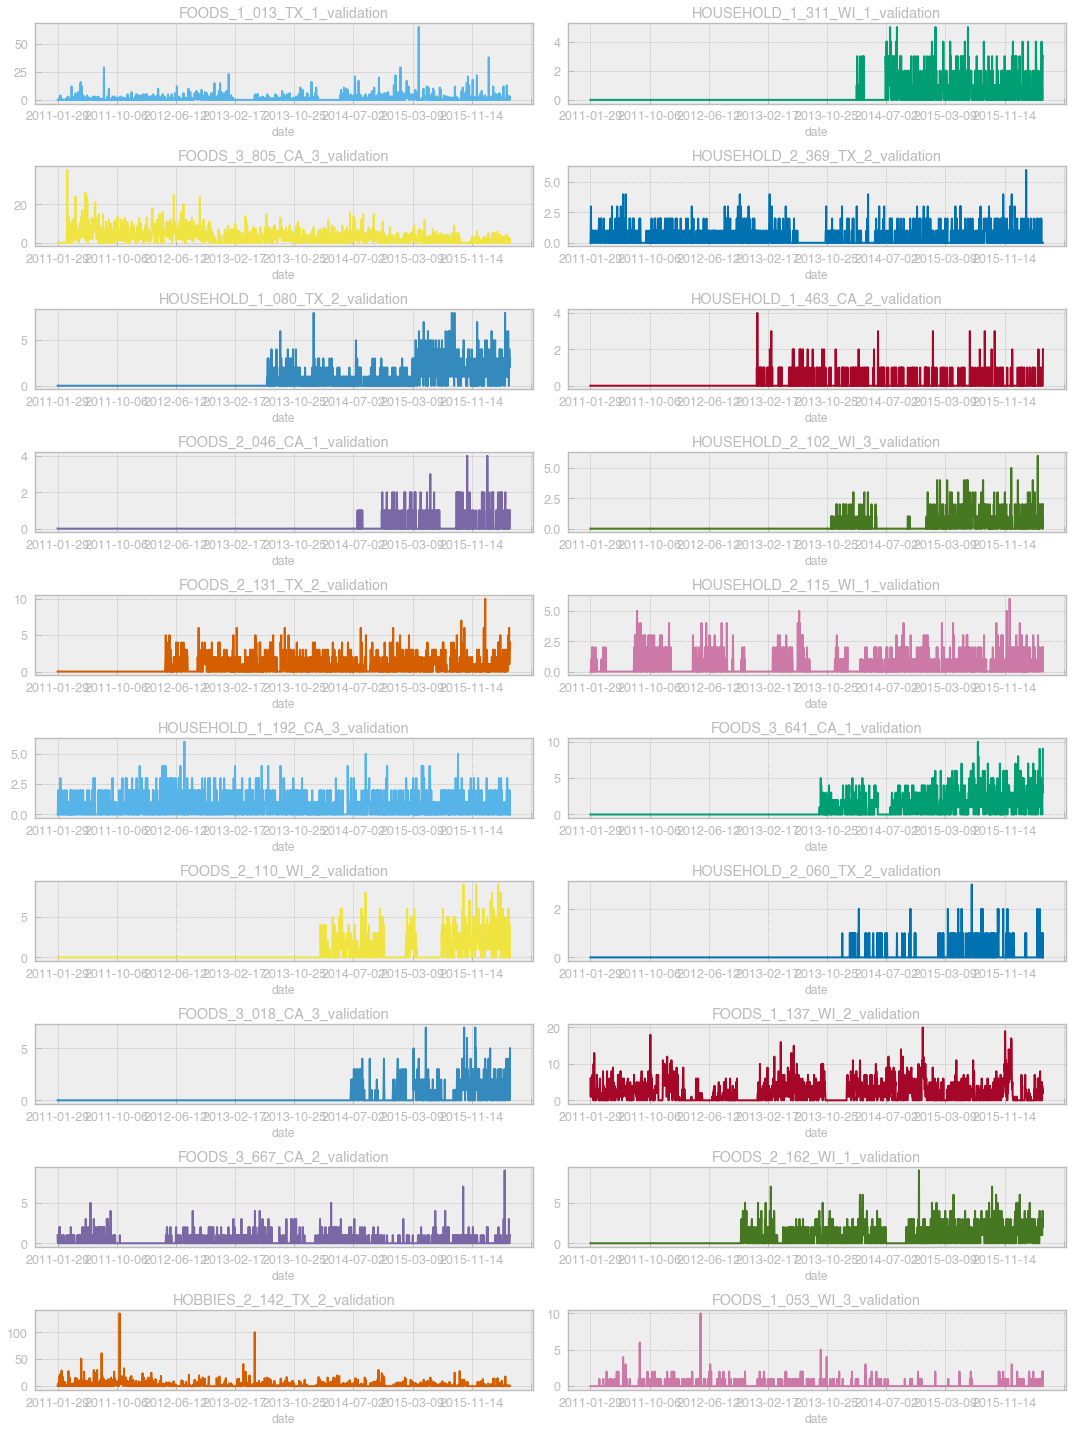

In [128]:
fig, axs=plt.subplots(10,2, figsize=(15,20))
axs = axs.flatten()
ax_idx=0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                               color=next(color_cycle),
                               ax=axs[ax_idx])
    ax_idx+=1
plt.tight_layout()
plt.show()

### Combined Sales over Time by Type
* We have several item types:
    * Hobbies
    * Household
    * Foods
* Lets plot the total demand over time for each type

In [134]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

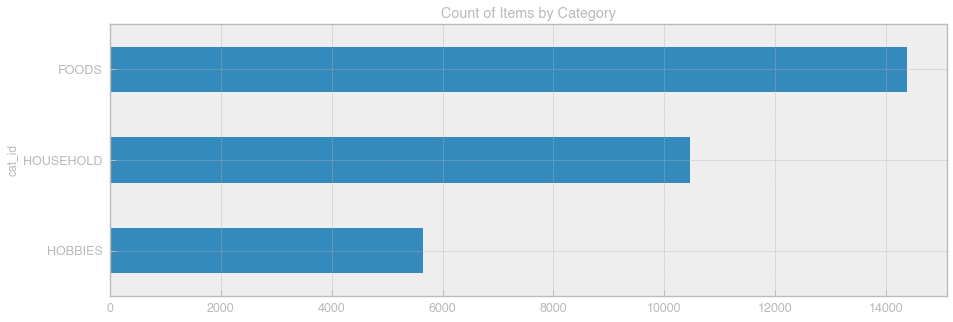

In [139]:
stv.groupby('cat_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,5), title='Count of Items by Category')
plt.show()

In [13]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')
past_sales.head()

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,HOBBIES_1_025_CA_1_validation,...,FOODS_3_803_WI_3_validation,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


In [165]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

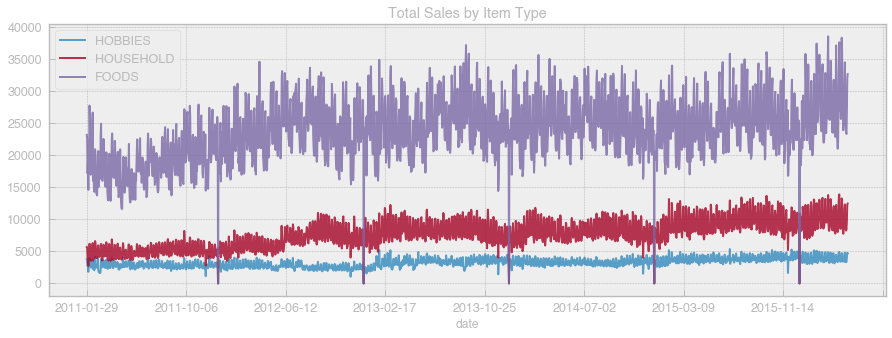

In [24]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

### Rollout of items being sold.
* We can see the some items come into supply that previously didn't exist. Similarly some items stop being sold completely.
* Lets plot the sales, but only count if item is selling or not selling (0 -> not selling, >0 -> selling)
    * 0이면 not selling, 0보다 크면 selling
    * np.clip(data,0,1)
        * 0보다 작으면 0, 1보다 크면 1 할당.
* This plot shows us that many items are being slowly introduced into inventory, so many of them will not register a sale at the beginning of the provided data.

In [29]:
# np.clip( ) 함수
### 모든 값이 0또는 1
past_sales_clipped['HOBBIES_1_002_CA_1_validation'].unique()

array([0, 1])

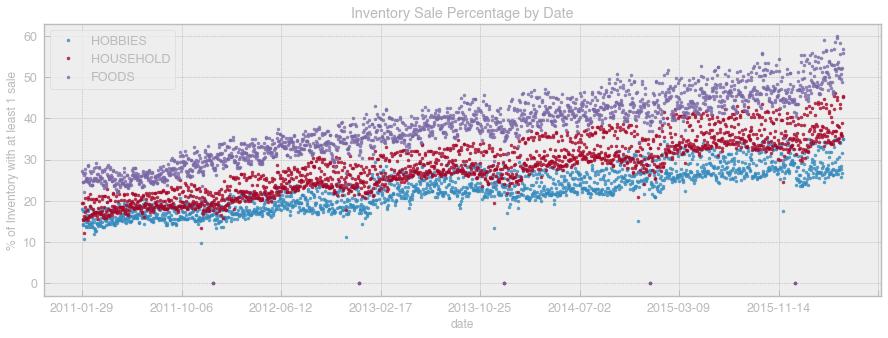

In [28]:
past_sales_clipped = past_sales.clip(0, 1)   # 판매되었으면 1, 안되었으면 0
for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \# 모든 데이터를 0 또는 1로 바꾼 상태에서 mean()을 하면 , 날짜별 HOBBIES,FOOD,HOUSEHOLD의 판매율이 나옴
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(stv['cat_id'].unique())
plt.show()

### Sales by Store
We are provided data for 10 unique stores. What are the total sales by stores?

* Note that some stores are more steady than others.
* CA_2 seems to have a big change occur in 2015

In [37]:
store_list = sellp['store_id'].unique()
sellp['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [51]:
past_sales.columns

Index(['HOBBIES_1_001_CA_1_validation', 'HOBBIES_1_002_CA_1_validation',
       'HOBBIES_1_003_CA_1_validation', 'HOBBIES_1_004_CA_1_validation',
       'HOBBIES_1_005_CA_1_validation', 'HOBBIES_1_006_CA_1_validation',
       'HOBBIES_1_007_CA_1_validation', 'HOBBIES_1_008_CA_1_validation',
       'HOBBIES_1_009_CA_1_validation', 'HOBBIES_1_010_CA_1_validation',
       ...
       'FOODS_3_818_WI_3_validation', 'FOODS_3_819_WI_3_validation',
       'FOODS_3_820_WI_3_validation', 'FOODS_3_821_WI_3_validation',
       'FOODS_3_822_WI_3_validation', 'FOODS_3_823_WI_3_validation',
       'FOODS_3_824_WI_3_validation', 'FOODS_3_825_WI_3_validation',
       'FOODS_3_826_WI_3_validation', 'FOODS_3_827_WI_3_validation'],
      dtype='object', length=30490)

In [ ]:
for s in store_list:
    store_items=[c for c in past_sales.columns if s in c]
    # store종류별 합계를 구하고, rolling으로 이동평균구함.
past_sales[store_items].sum(axis=1).plot(figsize=(15,5),alpha=0.8, title='not Rolling', color=next(color_cycle))
plt.legend(store_list)
plt.show()

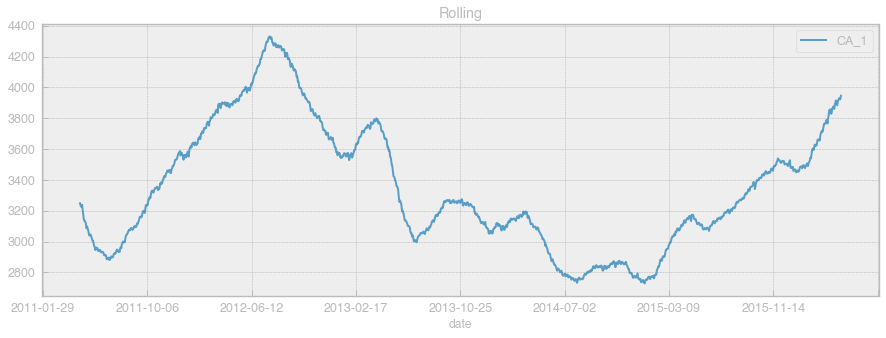

In [67]:
for s in store_list:
    store_items=[c for c in past_sales.columns if s in c]
    # store종류별 합계를 구하고, rolling으로 이동평균구함.
past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(15,5), alpha=0.8, title='Rolling')
plt.legend(store_list)
plt.show()

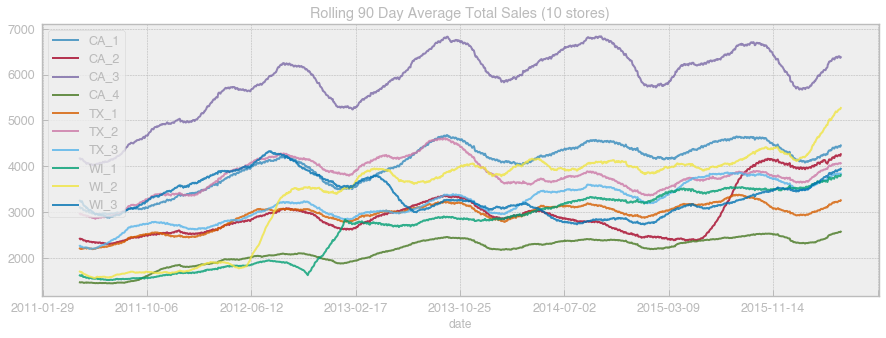

In [68]:
# store별 sales의 90일 rolling 값
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()